 Training on Sine Wave (Deep Generator)
[Sine GAN - Deep Generator] Epoch 1000/3000 | D Loss: 1.3648 | G Loss: 0.6536


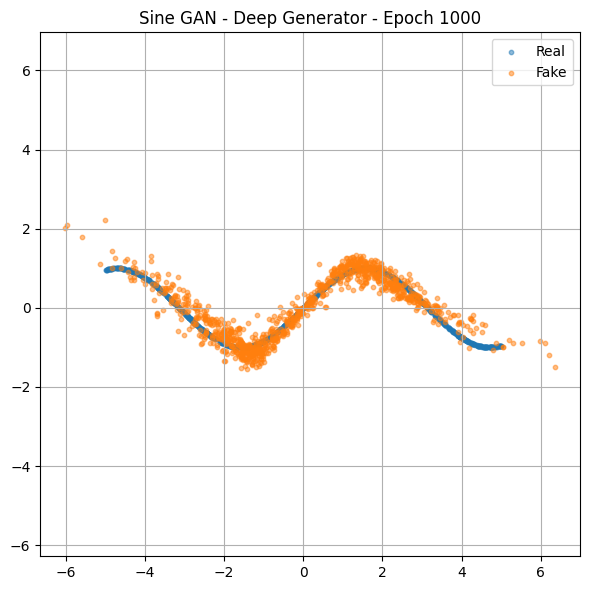

[Sine GAN - Deep Generator] Epoch 2000/3000 | D Loss: 1.3691 | G Loss: 0.7092


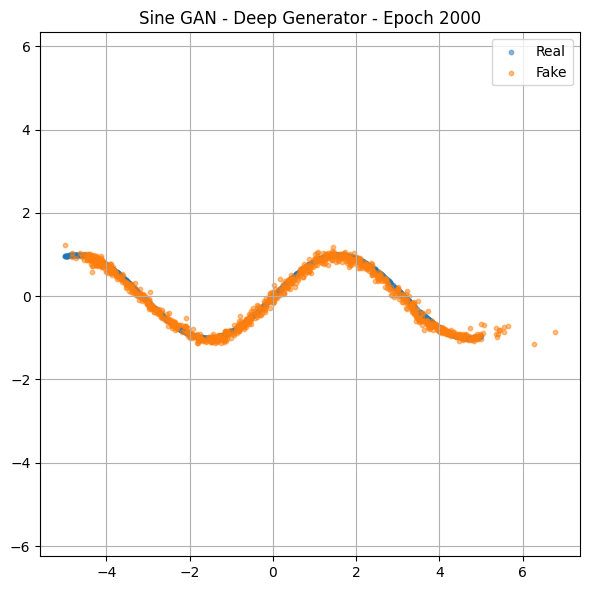

[Sine GAN - Deep Generator] Epoch 3000/3000 | D Loss: 1.3772 | G Loss: 0.7096


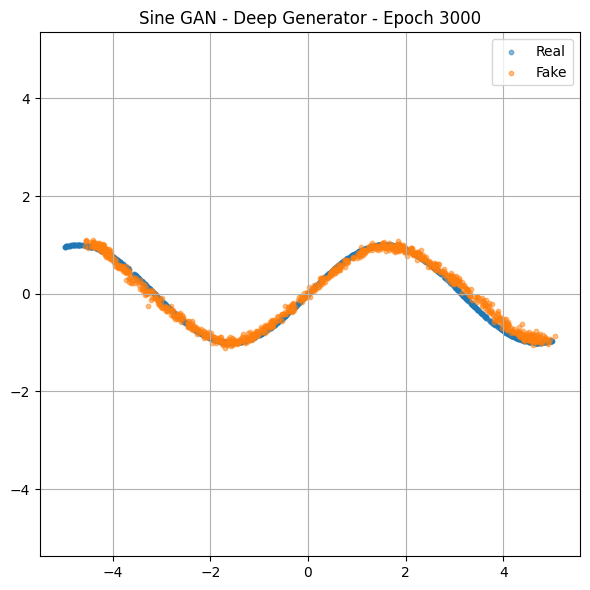

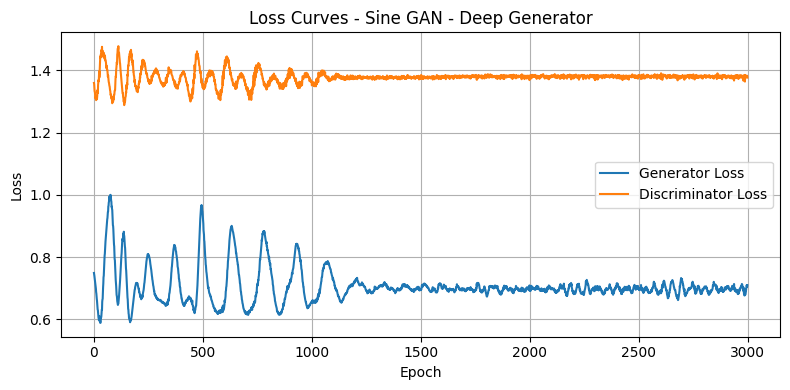


 Training on Ring of Gaussians (Deep Generator)
[Ring GAN - Deep Generator] Epoch 1000/3000 | D Loss: 1.3495 | G Loss: 0.7195


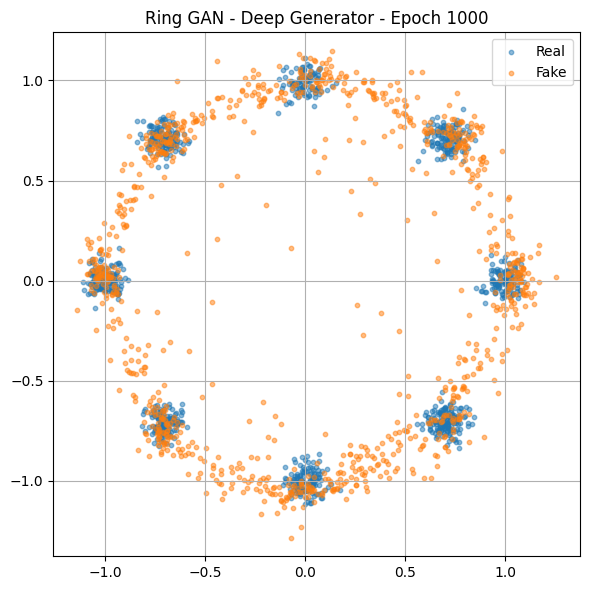

[Ring GAN - Deep Generator] Epoch 2000/3000 | D Loss: 1.3378 | G Loss: 0.7158


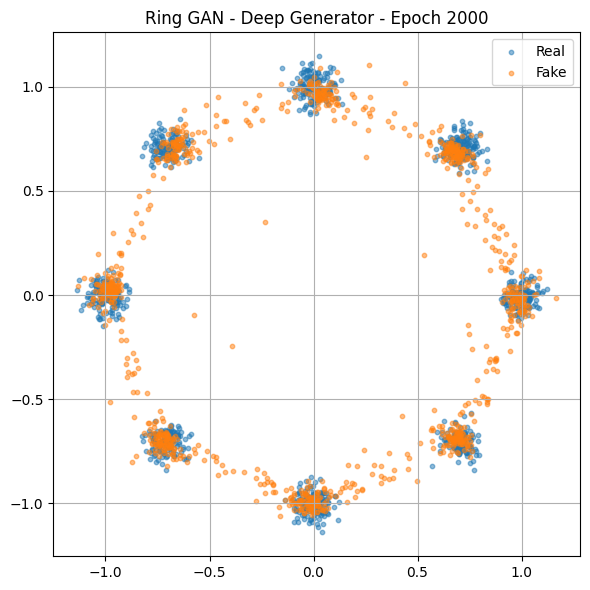

[Ring GAN - Deep Generator] Epoch 3000/3000 | D Loss: 1.3184 | G Loss: 0.7431


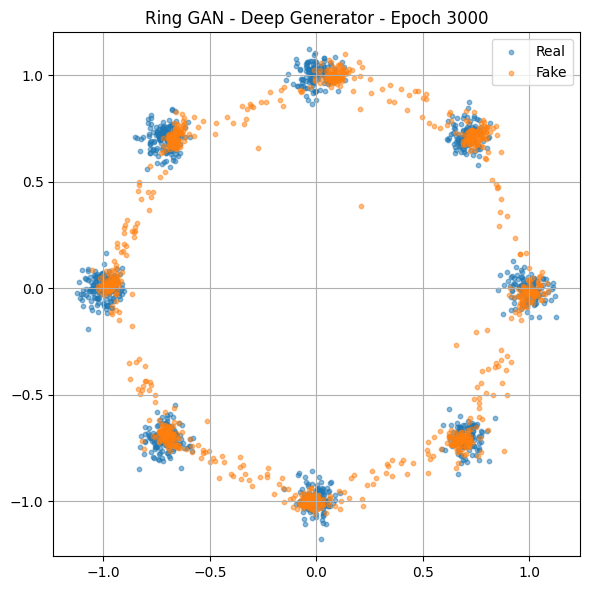

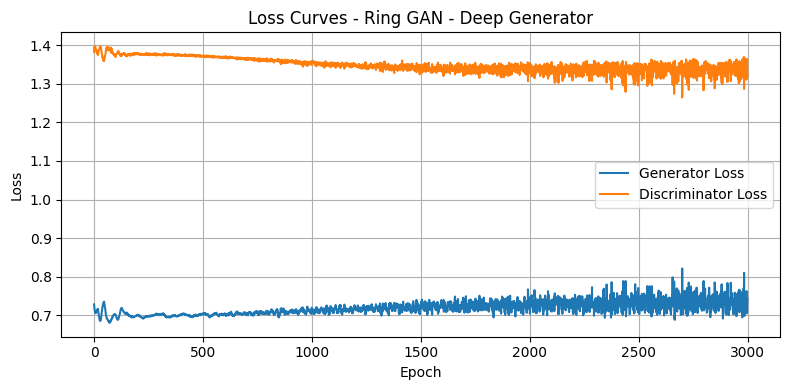


 Training on Ring of Gaussians (Simple Generator)
[Ring GAN - Simple Generator] Epoch 1000/3000 | D Loss: 1.0339 | G Loss: 1.1257


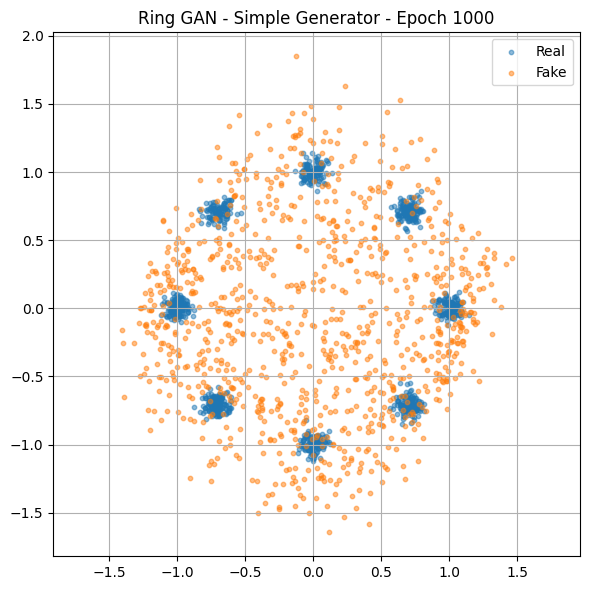

[Ring GAN - Simple Generator] Epoch 2000/3000 | D Loss: 0.9523 | G Loss: 1.4510


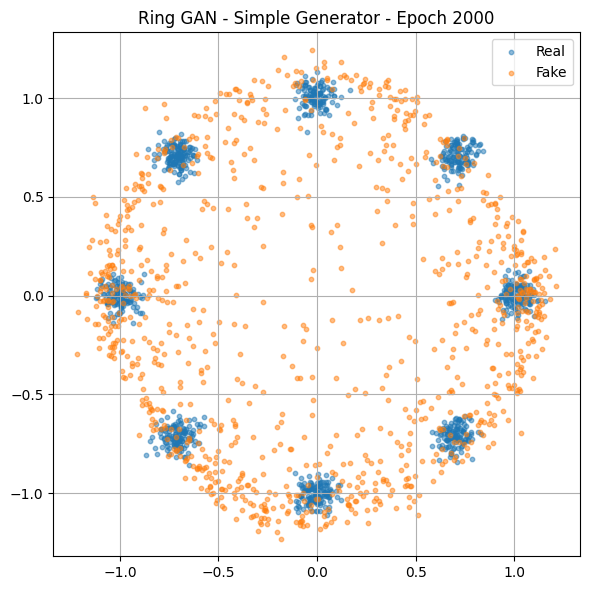

[Ring GAN - Simple Generator] Epoch 3000/3000 | D Loss: 0.9664 | G Loss: 1.5444


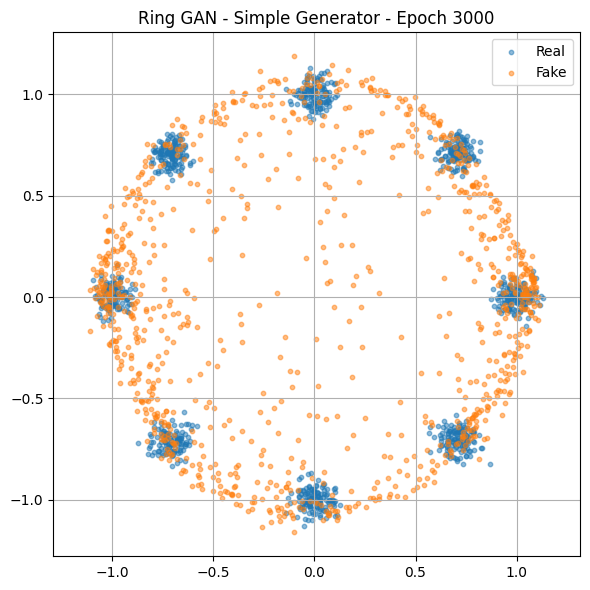

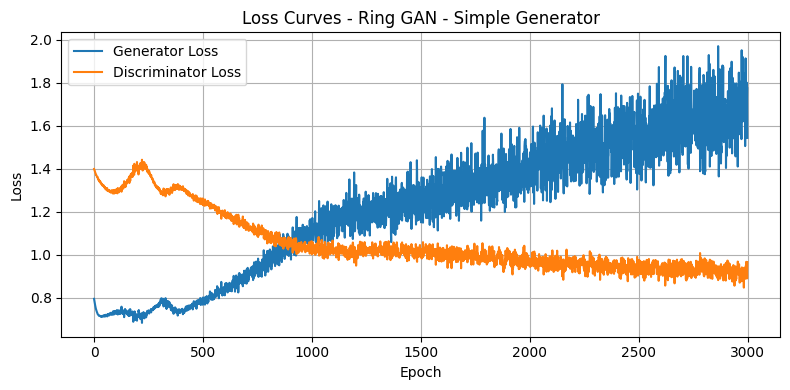

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set seeds and device
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Data Functions ===
def generate_sine_wave_data(n=1000):
    x = np.random.uniform(-5, 5, n)
    y = np.sin(x)
    data = np.stack([x, y], axis=1).astype(np.float32)
    return data

def generate_ring_gaussians(n=1000):
    centers = [(np.cos(t), np.sin(t)) for t in np.linspace(0, 2 * np.pi, 8, endpoint=False)]
    data = []
    for _ in range(n):
        center = centers[np.random.randint(0, len(centers))]
        point = np.random.randn(2) * 0.05 + np.array(center)
        data.append(point)
    return np.array(data, dtype=np.float32)

# === Generator Architectures ===
class GeneratorDeep(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 2)
        )

    def forward(self, z):
        return self.model(z)

class GeneratorSimple(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, z):
        return self.model(z)

# === Discriminator (shared) ===
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# === Training Function ===
def train_gan(real_data_fn, title, GeneratorClass, latent_dim=5, n_epochs=3000, batch_size=256, plot_every=1000):
    G = GeneratorClass(latent_dim).to(device)
    D = Discriminator().to(device)

    optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    G_losses, D_losses = [], []

    for epoch in range(1, n_epochs + 1):
        real = torch.tensor(real_data_fn(batch_size)).to(device)
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = G(z)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator update
        D_loss = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Generator update
        G_loss = criterion(D(fake), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        if epoch % plot_every == 0 or epoch == n_epochs:
            print(f"[{title}] Epoch {epoch}/{n_epochs} | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")
            plot_samples(G, real_data_fn, latent_dim, title, epoch)

    plot_losses(G_losses, D_losses, title)
    return G, D

# === Plotting Functions ===
def plot_samples(G, real_data_fn, latent_dim, title, epoch):
    G.eval()
    with torch.no_grad():
        z = torch.randn(1000, latent_dim).to(device)
        fake = G(z).cpu().numpy()
    real = real_data_fn(1000)

    plt.figure(figsize=(6, 6))
    plt.scatter(real[:, 0], real[:, 1], s=10, alpha=0.5, label='Real')
    plt.scatter(fake[:, 0], fake[:, 1], s=10, alpha=0.5, label='Fake')
    plt.legend()
    plt.title(f"{title} - Epoch {epoch}")
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    G.train()

def plot_losses(G_losses, D_losses, title):
    plt.figure(figsize=(8, 4))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.title(f"Loss Curves - {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Run All Experiments for Part 1 ===
if __name__ == "__main__":
    print(" Training on Sine Wave (Deep Generator)")
    train_gan(generate_sine_wave_data, "Sine GAN - Deep Generator", GeneratorClass=GeneratorDeep)

    print("\n Training on Ring of Gaussians (Deep Generator)")
    train_gan(generate_ring_gaussians, "Ring GAN - Deep Generator", GeneratorClass=GeneratorDeep)

    print("\n Training on Ring of Gaussians (Simple Generator)")
    train_gan(generate_ring_gaussians, "Ring GAN - Simple Generator", GeneratorClass=GeneratorSimple)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[500/3000] D Loss: 1.0789 | G Loss: 1.0053
[1000/3000] D Loss: 0.8606 | G Loss: 1.2096
[1500/3000] D Loss: 1.0113 | G Loss: 0.9333
[2000/3000] D Loss: 0.9211 | G Loss: 1.3246
[2500/3000] D Loss: 0.8901 | G Loss: 1.2007
[3000/3000] D Loss: 0.8286 | G Loss: 1.5522


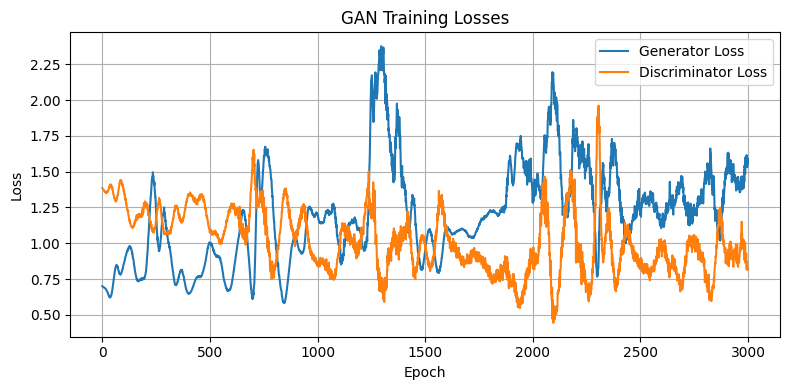

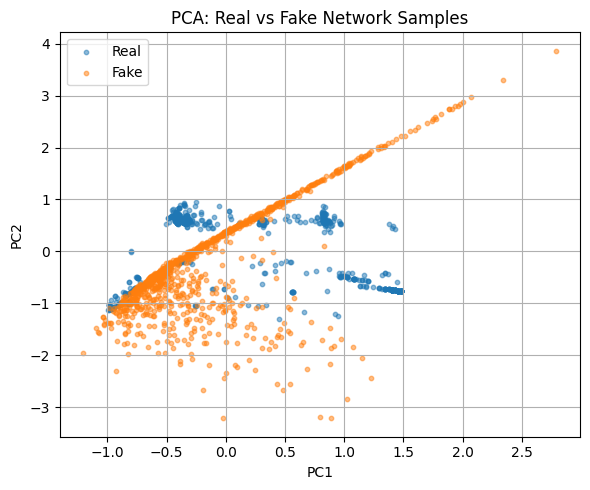

Mean Squared Error between real and fake feature means: 0.011133


array([[-0.3081042 ,  0.6196213 ,  0.01854822, ..., -0.2195555 ,
         0.3688948 ,  0.06795468],
       [-0.09462292,  0.15932427, -0.00302492, ..., -0.11194512,
         0.06090834, -0.06297018],
       [-0.0487602 ,  0.07214953,  0.0051875 , ..., -0.09790377,
         0.01217129, -0.07543264],
       ...,
       [-0.43521795,  0.8673959 ,  0.03678437, ..., -0.2943355 ,
         0.5179858 ,  0.11181115],
       [-0.15941963,  0.3225627 , -0.00090706, ..., -0.14203937,
         0.15760933, -0.00192685],
       [-0.2781415 ,  0.5205828 ,  0.00920378, ..., -0.21173462,
         0.29956818,  0.03674383]], dtype=float32)

In [21]:
# ========== STEP 1: Mount Google Drive ==========
from google.colab import drive
drive.mount('/content/drive')

# ========== STEP 2: Imports ==========
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import os

# ========== STEP 3: Load & Preprocess Data ==========
def load_data(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()  # Clean column names
    df = df[df['Label'].isin(['BENIGN', 'DoS Hulk'])]  # Filter classes

    drop_cols = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp', 'Label', 'Protocol']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    return X, scaler

# ========== STEP 4: Define GAN Models ==========
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# ========== STEP 5: GAN Training ==========
def train_gan(X_tensor, input_dim, latent_dim=64, epochs=3000, batch_size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    G = Generator(latent_dim, input_dim).to(device)
    D = Discriminator(input_dim).to(device)

    optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(D.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    G_losses, D_losses = [], []

    for epoch in range(1, epochs + 1):
        idx = np.random.randint(0, X_tensor.shape[0], batch_size)
        real = X_tensor[idx].to(device)
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = G(z)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator training
        D_loss = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Generator training
        G_loss = criterion(D(fake), real_labels)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        if epoch % 500 == 0 or epoch == epochs:
            print(f"[{epoch}/{epochs}] D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

    return G, G_losses, D_losses

# ========== STEP 6: Plot Losses ==========
def plot_losses(G_losses, D_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(D_losses, label='Discriminator Loss')
    plt.title("GAN Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ========== STEP 7: Visualize using PCA ==========
def plot_pca(real, fake):
    pca = PCA(n_components=2)
    pca.fit(real)
    real_2d = pca.transform(real)
    fake_2d = pca.transform(fake)

    plt.figure(figsize=(6, 5))
    plt.scatter(real_2d[:, 0], real_2d[:, 1], label='Real', alpha=0.5, s=10)
    plt.scatter(fake_2d[:, 0], fake_2d[:, 1], label='Fake', alpha=0.5, s=10)
    plt.title("PCA: Real vs Fake Network Samples")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ========== STEP 8: Save Outputs ==========
def save_model_and_data(G, scaler, latent_dim, path_prefix):
    os.makedirs(os.path.dirname(path_prefix), exist_ok=True)

    # Save Generator
    torch.save(G.state_dict(), f"{path_prefix}_generator.pth")

    # Generate fake samples
    G.eval()
    with torch.no_grad():
        z = torch.randn(1000, latent_dim).to(next(G.parameters()).device)
        fake_samples = G(z).cpu().numpy()

    # Inverse scale and save
    fake_unscaled = scaler.inverse_transform(fake_samples)
    pd.DataFrame(fake_unscaled).to_csv(f"{path_prefix}_fake_samples.csv", index=False)

    return fake_samples

# ========== STEP 9: Evaluate Generated Samples ==========
def evaluate_mse(real, fake):
    real_mean = np.mean(real, axis=0)
    fake_mean = np.mean(fake, axis=0)
    mse = mean_squared_error(real_mean, fake_mean)
    print(f"Mean Squared Error between real and fake feature means: {mse:.6f}")

# ========== STEP 10: Run Entire Pipeline ==========
# Load and preprocess data
path = '/content/drive/MyDrive/Generative modelling case study/Wednesday-workingHours.pcap_ISCX.csv'
X, scaler = load_data(path)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Train GAN
input_dim = X.shape[1]
latent_dim = 64
G, G_losses, D_losses = train_gan(X_tensor, input_dim, latent_dim)

# Visualizations & Evaluation
plot_losses(G_losses, D_losses)

G.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(next(G.parameters()).device)
    fake_samples = G(z).cpu().numpy()

plot_pca(X[:1000], fake_samples)
evaluate_mse(X[:1000], fake_samples)

# Save model and generated data
save_model_and_data(G, scaler, latent_dim, '/content/drive/MyDrive/Generative modelling case study/gan_output')

After mounting, double-check the file path in the error message to ensure it matches the location of your file in Google Drive. If the path is correct, you can rerun the original cell.